<a href="https://colab.research.google.com/github/mzsolt68/DogVision/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multi-class Dog Breed Classification (v2)

Building an end-to-end multi-class image classifier using TensorFlow

## 1. Problem

Identifying the breed of a dog from a given image

## 2. Data

We're going to use the Stanford Dogs dataset, which is available from several sources:
* The original project website: http://vision.stanford.edu/aditya86/ImageNetDogs/
* Inside the Tensorflow datasets: https://www.tensorflow.org/datasets/catalog/stanford_dogs
* On Kaggle: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset

## 3. Using the data

To make sure we don't have to download the data every time we come back to Colab:
* Download the data to the attached Google Drive if it doesn't already exists
* Copy the data to the Google drive if it isn't already there
* If the data already exists on Google Drive We'll import it

## 4. Features

Some information about the data:
* We are dealing with unstructured data (images), so it is probably best we use deeep learning/transfer learning.
* There are 120 breeds of dogs, this means there are 120 different classes).
* Around 10,000+ images in the training set (these images have labels)
* Around 10,000+ images in the test set


In [1]:
# Quick timestamp
import datetime
print(f"Notebook last run: {datetime.datetime.now()}")

Notebook last run: 2025-05-20 16:29:32.311146


In [2]:
# Import TensorFlow and check if we have GPU access
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

device_list = tf.config.list_physical_devices()
if "GPU" in [device.device_type for device in device_list]:
  print(f"[INFO] TensorFlow has GPU available to use.")
  print(f"[INFO] Accessible devices:\n{device_list}")
else:
  print(f"[INFO] TensorFlow does not have GPU available to use. Models may take a while to train.")
  print(f"[INFO] Accessible devices:\n{device_list}")

TensorFlow version: 2.18.0
[INFO] TensorFlow has GPU available to use.
[INFO] Accessible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Getting the data
Check if the target files exist in Google Drive and copy them to Colab. If the files doesn't exist, download them.

In [3]:
from pathlib import Path
from google.colab import drive

# 1. Mount Google Drive (this will bring up a pop-up to sign-in/authenticate)
# Note: This step is specifically for Google Colab, if you're working locally, you may need a different setup
# drive.mount("/content/drive")

# 2. Setup constants
# Note: For constants like this, you'll often see them created as variables with all capitals
TARGET_DRIVE_PATH = Path("drive/MyDrive/Dog_Vision/Data")
TARGET_FILES = ["images.tar", "annotation.tar", "lists.tar"]
TARGET_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs"

# 3. Setup local path
local_dir = Path("dog_vision_data")

# 4. Check if the target files exist in Google Drive, if so, copy them to Google Colab
if all((TARGET_DRIVE_PATH / file).is_file() for file in TARGET_FILES):
  print(f"[INFO] Copying Dog Vision files from Google Drive to local directory...")
  print(f"[INFO] Source dir: {TARGET_DRIVE_PATH} -> Target dir: {local_dir}")
  !cp -r {TARGET_DRIVE_PATH} {local_dir}
  print("[INFO] Good to go!")

else:
  # 5. If the files don't exist in Google Drive, download them
  print(f"[INFO] Target files not found in Google Drive.")
  print(f"[INFO] Downloading the target files... this shouldn't take too long...")
  for file in TARGET_FILES:
    # wget is short for "world wide web get", as in "get a file from the web"
    # -nc or --no-clobber = don't download files that already exist locally
    # -P = save the target file to a specified prefix, in our case, local_dir
    !wget -nc {TARGET_URL}/{file} -P {local_dir} # the "!" means to execute the command on the command line rather than in Python

  print(f"[INFO] Saving the target files to Google Drive, so they can be loaded later...")

  # 6. Ensure target directory in Google Drive exists
  TARGET_DRIVE_PATH.mkdir(parents=True, exist_ok=True)

  # 7. Copy downloaded files to Google Drive (so we can use them later and not have to re-download them)
  !cp -r {local_dir}/* {TARGET_DRIVE_PATH}/

[INFO] Copying Dog Vision files from Google Drive to local directory...
[INFO] Source dir: drive/MyDrive/Dog_Vision/Data -> Target dir: dog_vision_data
[INFO] Good to go!


In [4]:
# Make sure the files are exist
if local_dir.exists():
  print(str(local_dir) + "/")
  for item in local_dir.iterdir():
    print("  ", item.name)

dog_vision_data/
   images.tar
   lists.tar
   annotation.tar


In [5]:
# Untar the images, notes/tags
!tar -xf {local_dir}/images.tar -C {local_dir}
!tar -xf {local_dir}/annotation.tar -C {local_dir}
!tar -xf {local_dir}/lists.tar -C {local_dir}


We've got some new files.
Specifically:

* `train_list.mat` - a list of all the training set images.
* `test_list.mat` - a list of all the testing set images.
* `Images/` - a folder containing all of the images of dogs.
* `Annotation/` - a folder containing all of the annotations for each image.
* `file_list.mat` - a list of all the files (training and test list combined).


### Exploring the data
Before we build a model, it's good to explore the data to see what kind of data we're working with. For example:
* **Check at least 100+ random samples** if you have a large dataset.
* **Visualize!**
* **Check the distribution and other statistics.** How many samples are there? In a classification problem, how many classes and labels per class are there? etc.

#### Exploring the files lists

In [6]:
# Open the MATLAB files
import scipy

# Open lists of train and test .mat
train_list = scipy.io.loadmat(Path(local_dir, "train_list.mat"))
test_list = scipy.io.loadmat(Path(local_dir, "test_list.mat"))
file_list = scipy.io.loadmat(Path(local_dir, "file_list.mat"))

# Let's inspect the output and type of the train_list
train_list, type(train_list)

({'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct  9 08:36:13 2011',
  '__version__': '1.0',
  '__globals__': [],
  'file_list': array([[array(['n02085620-Chihuahua/n02085620_5927.jpg'], dtype='<U38')],
         [array(['n02085620-Chihuahua/n02085620_4441.jpg'], dtype='<U38')],
         [array(['n02085620-Chihuahua/n02085620_1502.jpg'], dtype='<U38')],
         ...,
         [array(['n02116738-African_hunting_dog/n02116738_6754.jpg'], dtype='<U48')],
         [array(['n02116738-African_hunting_dog/n02116738_9333.jpg'], dtype='<U48')],
         [array(['n02116738-African_hunting_dog/n02116738_2503.jpg'], dtype='<U48')]],
        dtype=object),
  'annotation_list': array([[array(['n02085620-Chihuahua/n02085620_5927'], dtype='<U34')],
         [array(['n02085620-Chihuahua/n02085620_4441'], dtype='<U34')],
         [array(['n02085620-Chihuahua/n02085620_1502'], dtype='<U34')],
         ...,
         [array(['n02116738-African_hunting_dog/n02116738_6754'], dtype=

In [7]:
# Check out the keys of the train_list dictionary
train_list.keys()

dict_keys(['__header__', '__version__', '__globals__', 'file_list', 'annotation_list', 'labels'])

In [8]:
# Check the length of the file_list key
print(f"Number of files in training list: {len(train_list['file_list'])}")
print(f"Number of files in testing list: {len(test_list['file_list'])}")
print(f"Number of files in full list: {len(file_list['file_list'])}")

Number of files in training list: 12000
Number of files in testing list: 8580
Number of files in full list: 20580


We have 20580 images total splitted in 60/40 ratio between train and test.

In [9]:
# Inspect the file_list key more
train_list['file_list']


array([[array(['n02085620-Chihuahua/n02085620_5927.jpg'], dtype='<U38')],
       [array(['n02085620-Chihuahua/n02085620_4441.jpg'], dtype='<U38')],
       [array(['n02085620-Chihuahua/n02085620_1502.jpg'], dtype='<U38')],
       ...,
       [array(['n02116738-African_hunting_dog/n02116738_6754.jpg'], dtype='<U48')],
       [array(['n02116738-African_hunting_dog/n02116738_9333.jpg'], dtype='<U48')],
       [array(['n02116738-African_hunting_dog/n02116738_2503.jpg'], dtype='<U48')]],
      dtype=object)

In [10]:
# Get a single filename
train_list['file_list'][0][0][0]

np.str_('n02085620-Chihuahua/n02085620_5927.jpg')

In [11]:
# Get a Python list of all file names for each list
train_file_list = list([item[0][0] for item in train_list["file_list"]])
test_file_list = list([item[0][0] for item in test_list["file_list"]])
full_file_list = list([item[0][0] for item in file_list["file_list"]])

len(train_file_list), len(test_file_list), len(full_file_list)

(12000, 8580, 20580)

In [12]:
# Get some random samples
import random

random.sample(train_file_list, k=10)

[np.str_('n02101556-clumber/n02101556_3909.jpg'),
 np.str_('n02096437-Dandie_Dinmont/n02096437_1678.jpg'),
 np.str_('n02091467-Norwegian_elkhound/n02091467_92.jpg'),
 np.str_('n02107683-Bernese_mountain_dog/n02107683_7104.jpg'),
 np.str_('n02105855-Shetland_sheepdog/n02105855_6417.jpg'),
 np.str_('n02106550-Rottweiler/n02106550_3993.jpg'),
 np.str_('n02107312-miniature_pinscher/n02107312_6380.jpg'),
 np.str_('n02088466-bloodhound/n02088466_1262.jpg'),
 np.str_('n02102177-Welsh_springer_spaniel/n02102177_1039.jpg'),
 np.str_('n02097130-giant_schnauzer/n02097130_5117.jpg')]

Make sure that the training set and the test set doesn't have common items

In [13]:
# How many files in the training set intersect with the testing set?
len(set(train_file_list).intersection(test_file_list))

0

#### Exploring the Annotation folder

In [14]:
import os

os.listdir(f"{local_dir}/Annotation")[:10]

['n02110185-Siberian_husky',
 'n02104029-kuvasz',
 'n02110627-affenpinscher',
 'n02109525-Saint_Bernard',
 'n02108915-French_bulldog',
 'n02101556-clumber',
 'n02099601-golden_retriever',
 'n02097658-silky_terrier',
 'n02096585-Boston_bull',
 'n02110063-malamute']

There are directories with dog breed names with several numbered files inside.
Each of the numbered files contains a HTML version.
For example, `Annotation/n02085620-Chihuahua/n02085620_10074`:

```
<annotation>
	<folder>02085620</folder>
	<filename>n02085620_10074</filename>
	<source>
		<database>ImageNet database</database>
	</source>
	<size>
		<width>333</width>
		<height>500</height>
		<depth>3</depth>
	</size>
	<segment>0</segment>
	<object>
		<name>Chihuahua</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>25</xmin>
			<ymin>10</ymin>
			<xmax>276</xmax>
			<ymax>498</ymax>
		</bndbox>
	</object>
</annotation>
```

The fields include the name and the size of the image, the label of the object, and where it is insid ethe image (bounding box).

Write a function to check the number of subfolders inside the `Annotation` folder (there should be 120 subfolder, one for each dog breed).

In [15]:
from pathlib import Path

def count_subfolders(path: str) -> int:
  """
    Count the number of subfolders in a given directory.

    Args:
    path (str): The path to the directory in which to count subfolders.

    Returns:
    int: The number of subfolders in the specified directory.

    Examples:
    >>> count_subfolders('/path/to/directory')
    3  # if there are 3 subfolders in the specified directory
  """
  return len([item for item in Path(path).iterdir() if item.is_dir()])

annotation_path = f"{local_dir}/Annotation"
folder_count = count_subfolders(annotation_path)
print(f"Number of subfolders in {annotation_path}: {folder_count}")

Number of subfolders in dog_vision_data/Annotation: 120


There are 120 subfolder of annotations, one for each class of dog.

But it looks like the class names are already in the filepaths.

In [16]:
# View a single training file pathname
train_file_list[0]

np.str_('n02085620-Chihuahua/n02085620_5927.jpg')

So we know, that image `n02085620_5927.jpg` should contain a `Chihuahua`.
Let's check.

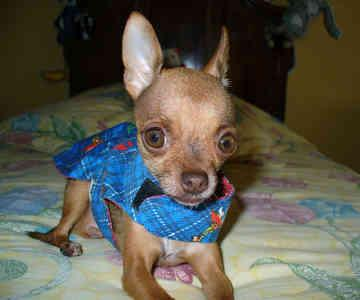

In [17]:
from IPython.display import Image
Image(Path(f"{local_dir}/Images/", train_file_list[0]))

#### Exploring the Images folder

We know that the image file names come in the format `class_name/image_name`, for example, `n02085620-Chihuahua/n02085620_5927.jpg`.

To make things a little simpler, let's create the following:

1. A mapping from folder name -> class name in dictionary form, for example, `{'n02113712-miniature_poodle': 'miniature_poodle',  'n02092339-Weimaraner': 'weimaraner',  'n02093991-Irish_terrier': 'irish_terrier'...}`. This will help us when visualizing our data from its original folder.
2. A list of all unique dog class names with simple formatting, for example, `['affenpinscher',  'afghan_hound',  'african_hunting_dog',  'airedale',  'american_staffordshire_terrier'...]`.


In [18]:
# Get a list of all image folders
image_folders = os.listdir(f"{local_dir}/Images")
image_folders[:10]

['n02110185-Siberian_husky',
 'n02104029-kuvasz',
 'n02110627-affenpinscher',
 'n02109525-Saint_Bernard',
 'n02108915-French_bulldog',
 'n02101556-clumber',
 'n02099601-golden_retriever',
 'n02097658-silky_terrier',
 'n02096585-Boston_bull',
 'n02110063-malamute']

In [19]:
# Create a foldername -> class name dictionary
folder_to_class_dictionary = {}
for folder_name in image_folders:
  class_name = folder_name.split("-")[1].lower().replace("_", " ")
  folder_to_class_dictionary[folder_name] = class_name

# Make sure there are 120 entries in the dictionary
assert len(folder_to_class_dictionary) == 120

In [20]:
list(folder_to_class_dictionary.items())[:10]

[('n02110185-Siberian_husky', 'siberian husky'),
 ('n02104029-kuvasz', 'kuvasz'),
 ('n02110627-affenpinscher', 'affenpinscher'),
 ('n02109525-Saint_Bernard', 'saint bernard'),
 ('n02108915-French_bulldog', 'french bulldog'),
 ('n02101556-clumber', 'clumber'),
 ('n02099601-golden_retriever', 'golden retriever'),
 ('n02097658-silky_terrier', 'silky terrier'),
 ('n02096585-Boston_bull', 'boston bull'),
 ('n02110063-malamute', 'malamute')]

In [21]:
# Get a list of unique dog names
dog_names = sorted(list(set(folder_to_class_dictionary.values())))
dog_names[:10]

['affenpinscher',
 'afghan hound',
 'african hunting dog',
 'airedale',
 'american staffordshire terrier',
 'appenzeller',
 'australian terrier',
 'basenji',
 'basset',
 'beagle']

Now we've got:
- a mapping from a folder name to a class name: `folder_to_class_dictionary`
- a list of unique dog breeds: `dog_names`

#### Visualize a group of random images

Create a function that takes a list of image paths and randomly selects 10 paths to display.
The function will:
1. Take a list of image paths as input.
2. Creat a grid of Matplotlib plots (e.g. 2x5)
3. Using `random.sample()`, selects 10 image paths from the input list.
4. Iterate through the flattened axes via `axes.flat` which is a reference to the attribute `numpy.ndarray.flat`.
5. Extract the sample path from the list of samples.
6. Get the sample title from the parent folder of the path using `Path.parent.stem` and then extract the formatted dog breed name by indexing `folder_to_class_name_dict`.
7. Read the image with `plt.imread()` and show it on the target ax with `ax.imshow()`.
8. Set the title of the plot to the parent folder name with `ax.set_title()` and turn the axis marks of with `ax.axis("off")` (this makes for pretty plots).
9. Show the plot with `plt.show()`.

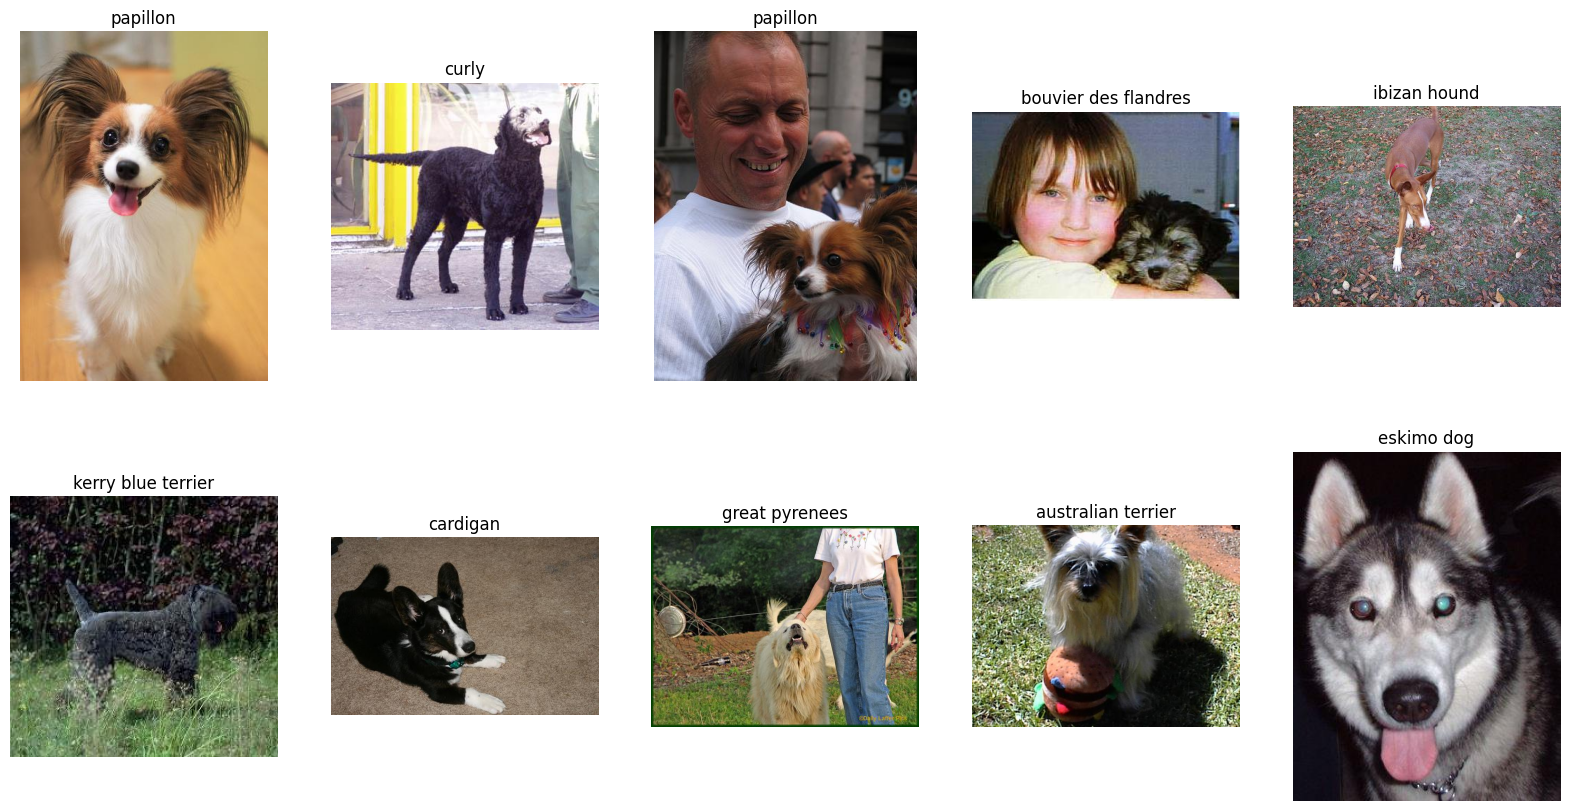

In [22]:
import random
from pathlib import Path
from typing import List
import matplotlib.pyplot as plt

def plot_10_random_images(image_paths: List[Path], extract_title: bool = True) -> None:
  """
    Plots 10 random images from a list of image paths.

    Args:
    image_paths (List[Path]): A list of image paths to plot.
    extract_title (bool): Whether to extract the title from the image path

    Returns:
    None
  """
  # Setup a grid of plots
  fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))

  # Get a list of random image paths
  samples = random.sample(image_paths, k=10)

  # Iterate through the flattened axes and corresponding image paths
  for i, ax in enumerate(axes.flat):
    # Get the image path
    image_path = samples[i]
    # Extract the parent directory name to use as the title (if neccesary)
    if extract_title:
      title = folder_to_class_dictionary[image_path.parent.stem]
    else:
      title = image_path.parent.stem

    # Read the image
    ax.imshow(plt.imread(image_path))
    # Set the title
    ax.set_title(title)
    # Turn the axis off
    ax.axis("off")

  # Show the plot
  plt.show()

plot_10_random_images(image_paths=[Path(f"{local_dir}/Images/") / path for path in train_file_list])


#### Exploring the distribution of the data

How many images of dog we have per breed?

A balanced distribution would mean, we have roughly the same number of images of every breed (e.g. 100 images per breed)

Let's see, how many images we have per breed? Write e function, that counts the images in a given directory:

1. Take in a target directory/folder.
2. Create a list of all the subdirectories/subfolders in the target folder.
3. Create an empty list, `image_class_counts` to append subfolders and their counts to.
4. Iterate through all of the subdirectories.
5. Get the class name of the target folder as the name of the folder.
6. Count the number of images in the target folder using the length of the list of image paths (we can get these with `Path().rglob(*.jpg)` where `*.jpg` means "all files with the extension `.jpg`".
7. Append a dictionary of `{"class_name": class_name, "image_count": image_count}` to the `image_class_counts` list (we create a list of dictionaries so we can turn this into a pandas DataFrame).
8. Return the `image_class_counts` list.

In [23]:
# Create a dictionary of image counts
from pathlib import Path
from typing import List, Dict

def count_images_in_subfolders(target_dir: str) -> List[Dict[str, int]]:
  """
    Counts the number of JPEG images in each subfolder in a given directory.
    Each subdirectory is assumed to represent a class, and the function counts
    the number of '.jpg' files within each one. The result is a list of
    dictionaries with the class name and corresponding image count.

    Args:
    target_dir (str): The path to the directory in which to count

    Returns:
    List[Dict[str, int]]: A list of dictionaries with 'class_name' and 'image_count' for each subdirectory.

    Examples:
        >>> count_images_in_subdirs('/path/to/directory')
        [{'class_name': 'beagle', 'image_count': 50}, {'class_name': 'poodle', 'image_count': 60}]
  """
  # Create a list of all the subfolders in the target directory
  image_dir = Path(target_dir)
  subfolders = [folder for folder in image_dir.iterdir() if folder.is_dir()]

  # Create an empty list to append image counts
  image_class_counts = []

  # Iterate through all of the subfolders
  for subfolder in subfolders:
    # Get the class name of the target folder as the name of the folder
    class_name = subfolder.name

    # Count the number of images in the target folder
    image_count = len(list(subfolder.rglob("*.jpg")))

    # Append a dictionary of class name and image count to count list
    image_class_counts.append({"class_name": class_name, "image_count": image_count})

  # Return the count list
  return image_class_counts


Run the function on the target directory and view the first few indexes

In [24]:
image_class_counts = count_images_in_subfolders(f"{local_dir}/Images")
image_class_counts[:10]

[{'class_name': 'n02110185-Siberian_husky', 'image_count': 192},
 {'class_name': 'n02104029-kuvasz', 'image_count': 150},
 {'class_name': 'n02110627-affenpinscher', 'image_count': 150},
 {'class_name': 'n02109525-Saint_Bernard', 'image_count': 170},
 {'class_name': 'n02108915-French_bulldog', 'image_count': 159},
 {'class_name': 'n02101556-clumber', 'image_count': 150},
 {'class_name': 'n02099601-golden_retriever', 'image_count': 150},
 {'class_name': 'n02097658-silky_terrier', 'image_count': 183},
 {'class_name': 'n02096585-Boston_bull', 'image_count': 182},
 {'class_name': 'n02110063-malamute', 'image_count': 178}]

Turn the `image_class_count` variable to a pandas `DataFrame`.

Sort the `DataFrame` by `image_count`.

In [25]:
import pandas as pd

image_counts_dataframe = pd.DataFrame(image_class_counts).sort_values("image_count", ascending=False)
image_counts_dataframe.head()

class_name  image_count
106         n02085936-Maltese_dog          252
38         n02088094-Afghan_hound          239
18   n02092002-Scottish_deerhound          232
15           n02112018-Pomeranian          219
36      n02090721-Irish_wolfhound          218

Map the `class_name` column to the `folder_to_class_dictionary` to easier read.

In [26]:
image_counts_dataframe["class_name"] = image_counts_dataframe["class_name"].map(folder_to_class_dictionary)
image_counts_dataframe.head()

class_name  image_count
106         maltese dog          252
38         afghan hound          239
18   scottish deerhound          232
15           pomeranian          219
36      irish wolfhound          218

Let's visualize the distribution of the data by turning the DataFrame into a plot.

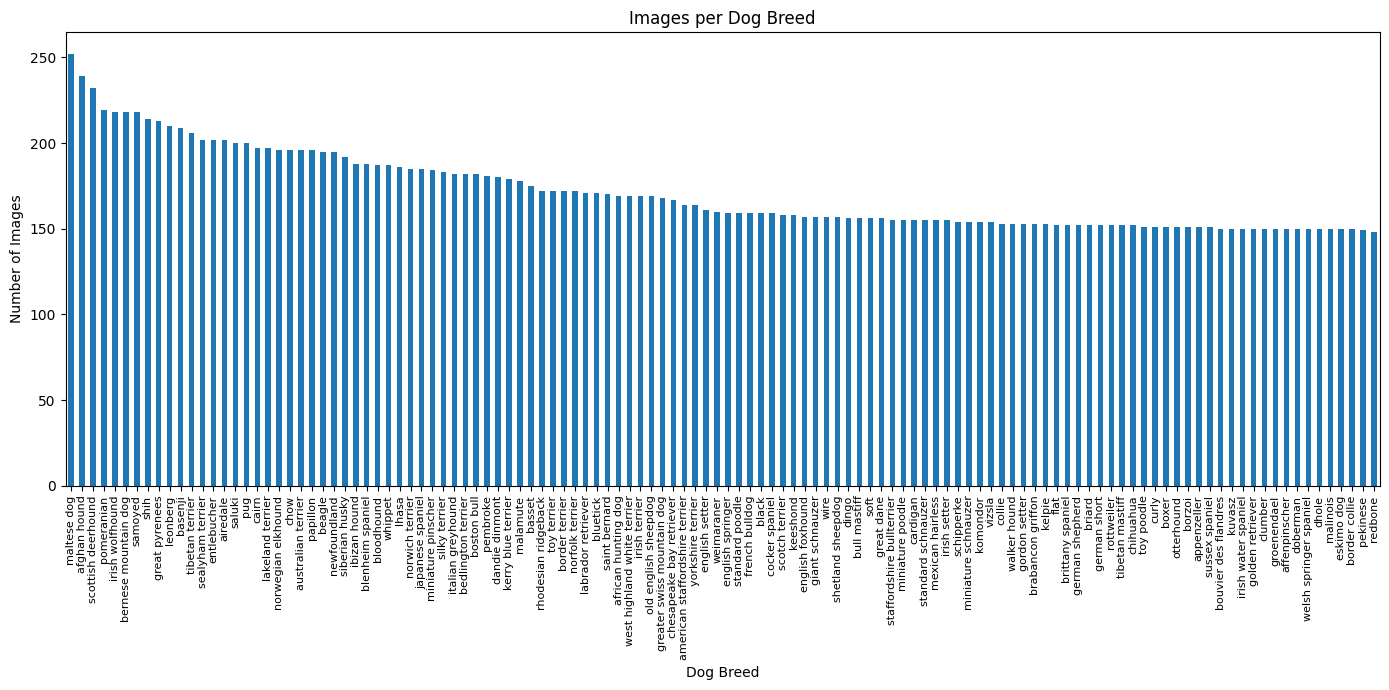

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
image_counts_dataframe.plot(kind="bar",
                            x="class_name",
                            y="image_count",
                            legend=False,
                            ax=plt.gca())
plt.title("Images per Dog Breed")
plt.xlabel("Dog Breed")
plt.ylabel("Number of Images")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

In [28]:
# Get some statistics about the DataFrame
image_counts_dataframe.describe()

image_count
count   120.000000
mean    171.500000
std      23.220898
min     148.000000
25%     152.750000
50%     159.500000
75%     186.250000
max     252.000000

### Creating training and test data split directories

After exploring the data, we need to create a training and test data splits. The original dataset already comes with this split, so we stick with these. But we also creating a smaller training set (about 10% of the original training set) for faster experimentation.

We create:

- a folder for training images `dog_vision_data/images/train`
- a folder for test images `dog_vision_data/images/test`
- inside each directory, make directories for each dog breed

In [29]:
from pathlib import Path

# Target directory for image splits
image_split_directory = Path(local_dir, "images_split")

# Training and test directories
train_dir = image_split_directory / "train"
test_dir = image_split_directory / "test"

# Create the target directories if it doesn't exist
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)
print(f"Directory {train_dir} is exists.")
print(f"Directory {test_dir} is exists.")

# Make folders for each dog breeds
for dog_name in dog_names:
  # Make training folder
  dog_train_dir = train_dir / dog_name
  dog_train_dir.mkdir(parents=True, exist_ok=True)

  # Make test folder
  dog_test_dir = test_dir / dog_name
  dog_test_dir.mkdir(parents=True, exist_ok=True)

# Check if 120 subfolder in each folder
assert count_subfolders(train_dir) == len(dog_names)
assert count_subfolders(test_dir) == len(dog_names)

Directory dog_vision_data/images_split/train is exists.
Directory dog_vision_data/images_split/test is exists.


In [30]:
# See the first 10 directories in the training directory
sorted([str(dir_name) for dir_name in train_dir.iterdir() if dir_name.is_dir()])[:10]

['dog_vision_data/images_split/train/affenpinscher',
 'dog_vision_data/images_split/train/afghan hound',
 'dog_vision_data/images_split/train/african hunting dog',
 'dog_vision_data/images_split/train/airedale',
 'dog_vision_data/images_split/train/american staffordshire terrier',
 'dog_vision_data/images_split/train/appenzeller',
 'dog_vision_data/images_split/train/australian terrier',
 'dog_vision_data/images_split/train/basenji',
 'dog_vision_data/images_split/train/basset',
 'dog_vision_data/images_split/train/beagle']

Create a function which will copy images from the `Images` folder into the respective directories inside `images_split/train` and `images_split/test`

Specifically:

1. Take in a list of source files to copy (e.g. `train_file_list`) and a target directory to copy files to.
2. Iterate through the list of sources files to copy (use `tqdm` which comes installed with Google Colab to create a progress bar of how many files have been copied).
3. Convert the source file path to a `Path` object.
4. Split the source file path and create a `Path` object for the destination folder (e.g. "n02112018-Pomeranian" -> "pomeranian").
5. Get the target file name (e.g. "n02112018-Pomeranian/n02112018_6208.jpg" -> "n02112018_6208.jpg").
6. Create a destination path for the source file to be copied to (e.g. `images_split/train/pomeranian/n02112018_6208.jpg`).
7. Ensure the destination directory exists, similar to the step we took in the previous section (you can't copy files to a directory that doesn't exist).
8. Print out the progress of copying (if necessary).
9. Copy the source file to the destination using Python's `shutil.copy2(src, dst)`.

In [31]:
from pathlib import Path
from shutil import copy2
from tqdm.auto import tqdm

def copy_files_to_target_directory(file_list: List[str],
                                   target_dir: str,
                                   images_dir: str = "dog_vision_data/Images",
                                   verbose: bool = False) -> None:
  """
  Copies a list of files from the images directory to a target directory.

  Parameters:
  file_list (list[str]): A list of file paths to copy.
  target_dir (str): The destination directory path where files will be copied.
  images_dir (str, optional): The directory path where the images are currently stored. Defaults to 'dog_vision_data/Images'.
  verbose (bool, optional): If set to True, the function will print out the file paths as they are being copied. Defaults to False.

  Returns:
  None
  """
  # Iterate through source files
  for file in tqdm(file_list):
    # Convert file path to Path object
    source_file_path = Path(images_dir) / Path(file)

    # Split the file path and create a Path object for destination folder
    file_class_name = folder_to_class_dictionary[Path(file).parts[0]]

    # Get the name of the image
    file_image_name = Path(file).name

    # Create destination path
    destination_path = Path(target_dir) / file_class_name / file_image_name

    # Check if destination directory exists
    destination_path.parent.mkdir(parents=True, exist_ok=True)

    # Print out copy message, if neccesary
    if verbose:
      print(f"[INFO] Copying: {source_file_path} to {destination_path}")

    # Copy the file to the destination
    copy2(source_file_path, destination_path)

Test the copy function by copying files from `train_file_list` to `train_dir`

In [32]:
copy_files_to_target_directory(file_list=train_file_list,
                               target_dir=train_dir,
                               verbose=False)

  0%|          | 0/12000 [00:00<?, ?it/s]

Copy files from `test_file_list` to `test_dir`

In [33]:
copy_files_to_target_directory(file_list=test_file_list,
                               target_dir=test_dir,
                               verbose=False)

  0%|          | 0/8580 [00:00<?, ?it/s]

Check if the number of files in the `train_file_list` is the same as the number of images in the `train_dir` (and also check the test files).

In [34]:
# Get a list of all .jpg file paths in train and test image folders
train_image_paths = list(train_dir.rglob("*.jpg"))
test_image_paths = list(test_dir.rglob("*.jpg"))

# Make sure the number of images in the train and test directories equals the number of files in the original lists
assert len(train_image_paths) == len(train_file_list)
assert len(test_image_paths) == len(test_file_list)

print(f"Number of images in {train_dir}: {len(train_image_paths)}")
print(f"Number of images in {test_dir}: {len(test_image_paths)}")

Number of images in dog_vision_data/images_split/train: 12000
Number of images in dog_vision_data/images_split/test: 8580


Plot some random images from the `train_image_path`

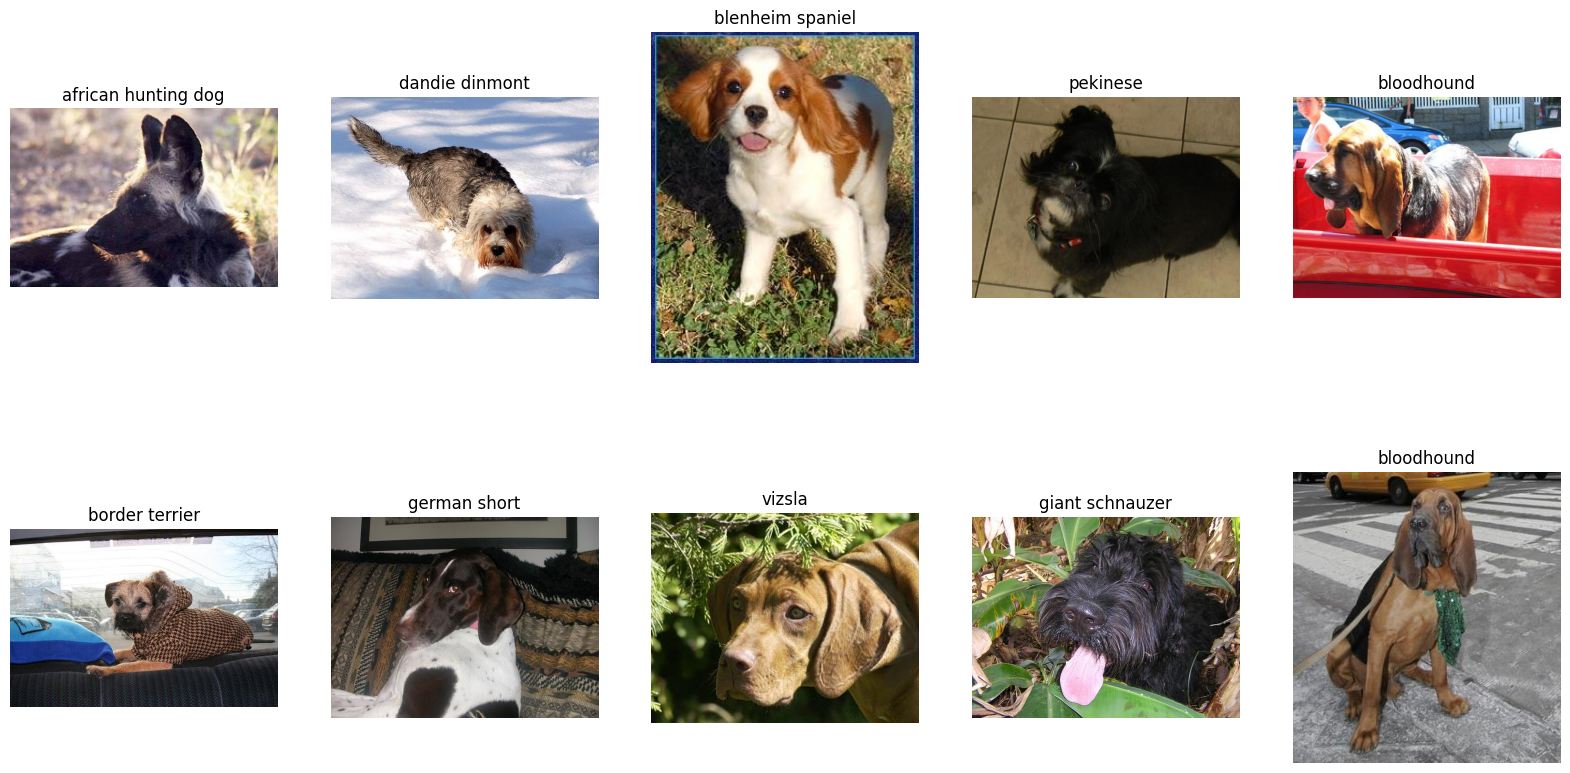

In [35]:
plot_10_random_images(image_paths=train_image_paths,
                      extract_title=False)

#### Create a 10% training dataset split

To make model experiments faster, we create a smaller (~10%) training dataset in the `images_split` directory.
To make this dataset, we copy a random 10% of the existing training set to a new folder, named `images_split/train_10_percent`.

In [36]:
# Create the 10% folder
train_10_percent_dir = image_split_directory / "train_10_percent"
train_10_percent_dir.mkdir(parents=True, exist_ok=True)

In [37]:
os.listdir(image_split_directory)

['test', 'train', 'train_10_percent']

In [38]:
# Take 10% random sample from the train_image_paths
import random

random.seed(42)

train_image_paths_10_percent = random.sample(population=train_image_paths,
                                             k=int(len(train_image_paths) * 0.1))

print(f"Original number of images: {len(train_image_paths)}")
print(f"Number of images in 10% sample: {len(train_image_paths_10_percent)}")
print("First 5 random images in 10% sample:")
train_image_paths_10_percent[:5]

Original number of images: 12000
Number of images in 10% sample: 1200
First 5 random images in 10% sample:


[PosixPath('dog_vision_data/images_split/train/boston bull/n02096585_9912.jpg'),
 PosixPath('dog_vision_data/images_split/train/afghan hound/n02088094_3233.jpg'),
 PosixPath('dog_vision_data/images_split/train/ibizan hound/n02091244_5774.jpg'),
 PosixPath('dog_vision_data/images_split/train/english setter/n02100735_4333.jpg'),
 PosixPath('dog_vision_data/images_split/train/black/n02089078_663.jpg')]

Copy the 10% random sample to the sample directory

In [39]:
for source_file_path in tqdm(train_image_paths_10_percent):
  # Create the destination file path
  destination_file_and_image_name = Path(*source_file_path.parts[-2:])
  destination_path = train_10_percent_dir / destination_file_and_image_name

  # Create the target directory if not exists
  target_class_dir = destination_path.parent
  if not target_class_dir.is_dir():
    target_class_dir.mkdir(parents=True, exist_ok=True)

  # Copy the file to the destination
  copy2(source_file_path, destination_path)

  0%|          | 0/1200 [00:00<?, ?it/s]

Check the 10% set distribution and make sure we've got some images for each class.

In [40]:
# Count images in the 10% directory
train_10_percent_image_class_count  = count_images_in_subfolders(train_10_percent_dir)
train_10_percent_image_class_count_df = pd.DataFrame(train_10_percent_image_class_count).sort_values("image_count", ascending=True)
train_10_percent_image_class_count_df.head()

class_name  image_count
33   norfolk terrier            3
23         chihuahua            4
61    dandie dinmont            4
64        pomeranian            4
100      groenendael            5

In [41]:
# Check how many subfolders are in the 10% directory
print(len(train_10_percent_image_class_count_df))

120


Plot the distribution of the 10% training set

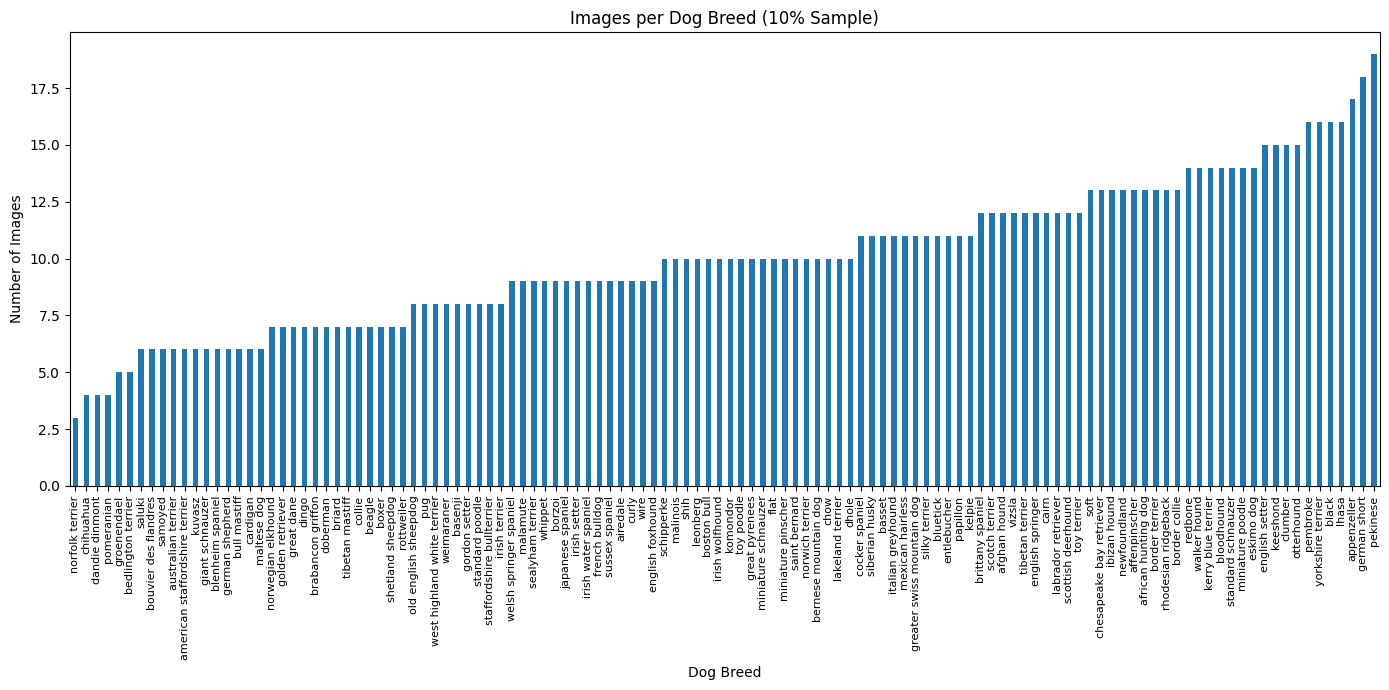

In [42]:
plt.figure(figsize=(14, 7))
train_10_percent_image_class_count_df.plot(kind="bar",
                                           x="class_name",
                                           y="image_count",
                                           legend=False,
                                           ax=plt.gca())

plt.title("Images per Dog Breed (10% Sample)")
plt.xlabel("Dog Breed")
plt.ylabel("Number of Images")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()
#

### Turning datasets into TensorFlow dataset(s)

We need to convert the images to tensors to train the ML model.
The reason why we sort the images to the classic image classification format (where the class name is the directory name) is, because TensorFlow offers some utility functions to load data from this format.

| Function |	Description |
|-----------------------------------|-----------------------------------|
| tf.keras.utils.image_dataset_from_directory() |	Creates a tf.data.Dataset from image files in a directory. |
| tf.keras.utils.audio_dataset_from_directory() |	Creates a tf.data.Dataset from audio files in a directory. |
| tf.keras.utils.text_dataset_from_directory() |	Creates a tf.data.Dataset from text files in a directory. |
| tf.keras.utils.timeseries_dataset_from_array() |	Creates a dataset of sliding windows over a timeseries provided as array. |

We'll use the `tf.keras.utils.image_dataset_from_directory()` with the following parameters:

- `directory` = the target directory we'd like to turn into a `tf.data.Dataset`.
- `label_mode` = the kind of labels we'd like to use, in our case it's `"categorical"` since we're dealing with a multi-class classification problem (we would use `"binary"` if we were working with binary classifcation problem).
- `batch_size` = the number of images we'd like our model to see at a time (due to computation limitations, our model won't be able to look at every image at once so we split them into small batches and the model looks at each batch individually), generally 32 is a good value to start, this means our model will look at 32 images at a time (this number is flexible).
- `image_size` = the size we'd like to shape our images to before we feed them to our model (height x width).
- `shuffle` = whether we'd like our dataset to be shuffled to randomize the order.
- `seed` = if we're shuffling the order in a random fashion, do we want that to be reproducible?

Make 3 `tf.data.Dataset` for `train`, `test` and `10%_train` datasets.

In [43]:
import tensorflow as tf

# Create some constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Create 10% train dataset
train_10_percent_ds = tf.keras.utils.image_dataset_from_directory(directory=train_10_percent_dir,
                                                                  label_mode="categorical",
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMG_SIZE,
                                                                  shuffle=True,
                                                                  seed=SEED)

# Create full train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                       label_mode="categorical",
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE,
                                                       shuffle=True,
                                                       seed=SEED)

# Create test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                      label_mode="categorical",
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMG_SIZE,
                                                      shuffle=False,
                                                      seed=SEED)


Found 1200 files belonging to 120 classes.
Found 12000 files belonging to 120 classes.
Found 8580 files belonging to 120 classes.


In [44]:
# Check the 10% dataset
train_10_percent_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

In [45]:
# Check a single batch in a dataset
image_batch, label_batch = next(iter(train_ds))
image_batch.shape, label_batch.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32, 120]))

In [46]:
# Get a single sample from a batch
print(f"Single image tensor:\n {image_batch[0]}\n")
print(f"Single label tensor:\n {label_batch[0]}")
print(f"Single sample class name: {dog_names[tf.argmax(label_batch[0])]}")


Single image tensor:
 [[[196.61607  174.61607  160.61607 ]
  [197.84822  175.84822  161.84822 ]
  [200.       178.       164.      ]
  ...
  [ 60.095097  79.75804   45.769207]
  [ 61.83293   71.22575   63.288315]
  [ 77.65755   83.65755   81.65755 ]]

 [[196.       174.       160.      ]
  [197.83876  175.83876  161.83876 ]
  [199.07945  177.07945  163.07945 ]
  ...
  [ 94.573715 110.55229   83.59694 ]
  [125.869865 135.26268  127.33472 ]
  [122.579605 128.5796   126.579605]]

 [[195.73691  173.73691  159.73691 ]
  [196.896    174.896    160.896   ]
  [199.       177.       163.      ]
  ...
  [ 26.679413  38.759026  20.500835]
  [ 24.372307  31.440136  26.675896]
  [ 20.214453  26.214453  24.214453]]

 ...

 [[ 61.57369   70.18976  104.72547 ]
  [189.91965  199.61607  213.28572 ]
  [247.26637  255.       252.70387 ]
  ...
  [113.40158   83.40158   57.40158 ]
  [110.75214   78.75214   53.752136]
  [107.37048   75.37048   50.370483]]

 [[ 61.27007   69.88614  104.42185 ]
  [188.93079  1

#### Visualizing images from TensorFlow Dataset

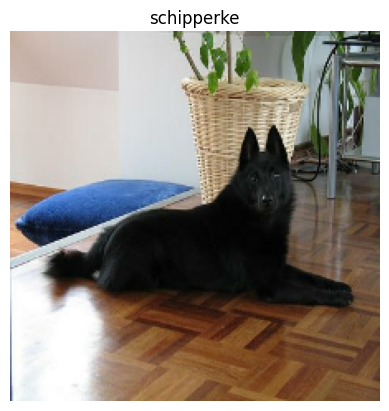

In [47]:
# Plot a single image
plt.imshow(image_batch[0].numpy().astype("uint8"))
plt.title(dog_names[tf.argmax(label_batch[0])])
plt.axis("off");

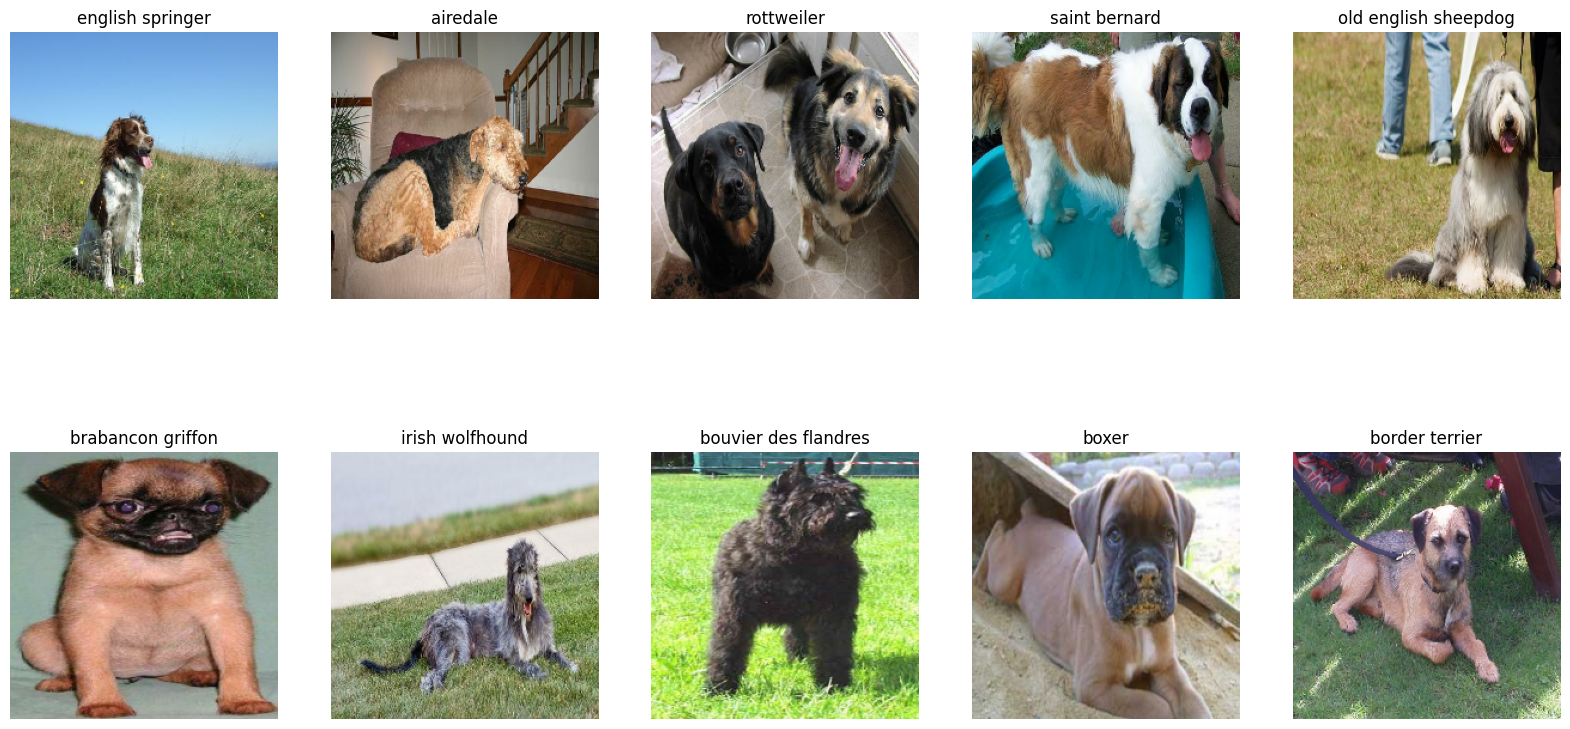

In [48]:
# Plot multiple images

# Create multiple subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# Iterate through a single batch and plot images
for images, labels in train_ds.take(count=1):
  for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].numpy().astype("uint8"))
    ax.set_title(dog_names[tf.argmax(labels[i])])
    ax.axis("off")

#### Getting labels from TensorFlow Datasets

In [49]:
# Get the first 5 file paths from the training dataset
train_ds.file_paths[:5]

['dog_vision_data/images_split/train/boston bull/n02096585_1753.jpg',
 'dog_vision_data/images_split/train/kerry blue terrier/n02093859_855.jpg',
 'dog_vision_data/images_split/train/border terrier/n02093754_2281.jpg',
 'dog_vision_data/images_split/train/rottweiler/n02106550_11823.jpg',
 'dog_vision_data/images_split/train/airedale/n02096051_5884.jpg']

In [50]:
# Get the class names
class_names = train_ds.class_names
class_names[:5]

['affenpinscher',
 'afghan hound',
 'african hunting dog',
 'airedale',
 'american staffordshire terrier']

In [51]:
# Make sure the class names are the same in each dataset
assert set(train_10_percent_ds.class_names) == set(train_ds.class_names) == set(test_ds.class_names)

#### Configuring the datasets for performance

We're going to call three methods on our dataset to optimize it for performance:

- `cache()` - Cache the elements in the dataset in memory or a target folder (speeds up loading).
- `shuffle()` - Shuffle a set number of samples in preparation for loading (this will mean our samples and batches of samples will be shuffled), for example, setting `shuffle(buffer_size=1000)` will prepare and shuffle 1000 elements of data at a time.
- `prefetch()` - Prefetch the next batch of data and prepare it for computation whilst the previous one is being computed on (can scale to multiple prefetches depending on hardware availability). TensorFlow can automatically configure how many elements/batches to prefetch by setting `prefetch(buffer_size=tf.data.AUTOTUNE)`.

In [52]:
AUTOTUNE = tf.data.AUTOTUNE

# Shuffle and optimize performance on training datasets
train_10_percent_ds = train_10_percent_ds.cache().shuffle(buffer_size=10*BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.cache().shuffle(buffer_size=100*BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Don't shuffle the test dataset
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating a neural network with TensorFlow

#### Create a base model

Instead of building a neural network from scratch, we'll use transfer learning. We're going to use a pretraned model from `tf.keras.applications`, specifically the `tf.keras.applications.effcientnet_v2.EfficientNetV2B0()` model.

Let's create an instance of the model and calll it `base_model`.

In [53]:
# Create the input shape to our model
INPUT_SHAPE = (*IMG_SIZE, 3)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_shape=INPUT_SHAPE
)


29403144/29403144 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Information about the base_model
base_model.summary()

In [55]:
# Number of layers
print(f"Number of layers in the base model: {len(base_model.layers)}")

Number of layers in the base model: 273


Because the used model has 1000 output classes and we want classify 120 different dog breeds, we need to change the model configuration. We want to use our own output layer.

In [56]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_shape=INPUT_SHAPE
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [57]:
# Check the number of parameters the model has
base_model.count_params()

5919312

Write e function that count the trainable and non-trainable parameters of a model.

In [58]:
import numpy as np

def count_parameters(model, print_output=True):
  """
  Counts the number of trainable, non-trainable and total parameters of a given model.
  """
  trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.trainable_weights])
  non_trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.non_trainable_weights])
  total_parameters = trainable_parameters + non_trainable_parameters
  if print_output:
    print(f"Model {model.name} parameter counts:")
    print(f"Total parameters: {total_parameters}")
    print(f"Trainable parameters: {trainable_parameters}")
    print(f"Non-trainable parameters: {non_trainable_parameters}")
  else:
    return total_parameters, trainable_parameters, non_trainable_parameters

count_parameters(base_model)


Model efficientnetv2-b0 parameter counts:
Total parameters: 5919312
Trainable parameters: 5858704
Non-trainable parameters: 60608


The model has more than 5 million trainable parameter. To speed up the learning process, we'll *freeze* the layers of the base model and only train the custom top layers to suit our problem.

In [60]:
# Freeze the base model
base_model.trainable = False
base_model.trainable
count_parameters(base_model)

Model efficientnetv2-b0 parameter counts:
Total parameters: 5919312.0
Trainable parameters: 0.0
Non-trainable parameters: 5919312


We need to reshape our data to match the input shape of the model.

The shape of our data: `(224, 224, 3) (height, width, color channels)`

The expected input shape of the model: `(None, 224, 224, 3) (batch_size, height, width, color channels)`

We need to add one dimension to our data.

In [62]:
# Current image shape
image_shape_without_batch = image_batch[0].shape

# Add a batch dimension to our single image
image_shape_with_batch = tf.expand_dims(input=image_batch[0], axis=0).shape

print(f"Single image shape without batch: {image_shape_without_batch}")
print(f"Single image shape with batch: {image_shape_with_batch}")

Single image shape without batch: (224, 224, 3)
Single image shape with batch: (1, 224, 224, 3)


In [64]:
# Try to extract features from a single image using the base_model
feature_extraction = base_model(tf.expand_dims(image_batch[0], axis=0))
feature_extraction

<tf.Tensor: shape=(1, 7, 7, 1280), dtype=float32, numpy=
array([[[[-2.19177052e-01, -3.44185233e-02, -1.40321687e-01, ...,
          -1.44454598e-01, -2.73809850e-01, -7.41252303e-02],
         [-8.69670361e-02, -6.48749396e-02, -2.14547113e-01, ...,
          -4.57212254e-02, -2.77900100e-01, -8.20885971e-02],
         [-2.76872933e-01, -8.26780424e-02, -3.85153778e-02, ...,
          -2.72129059e-01, -2.52802253e-01, -2.28106007e-01],
         ...,
         [-1.01603836e-01, -3.55146527e-02, -2.23027036e-01, ...,
          -2.26227745e-01, -8.61773863e-02, -1.60451159e-01],
         [-5.87607883e-02, -4.65545198e-03, -1.06192790e-01, ...,
          -2.87548564e-02, -9.06914845e-02, -1.82624489e-01],
         [-6.27618283e-02, -1.38620916e-03,  1.52714215e-02, ...,
          -7.85452034e-03, -1.84584767e-01, -2.62404919e-01]],

        [[-2.17334047e-01, -1.10280916e-01, -2.74605274e-01, ...,
          -2.22405165e-01, -2.74738312e-01, -1.01998910e-01],
         [-1.40700534e-01, -1.6

In [65]:
# Turn the feature extraction into a feature vector using Average pooling
feature_vector = tf.keras.layers.GlobalAveragePooling2D()(feature_extraction)
feature_vector

<tf.Tensor: shape=(1, 1280), dtype=float32, numpy=
array([[-0.11521895, -0.0447655 , -0.12476546, ..., -0.09118075,
        -0.08420843, -0.07769414]], dtype=float32)>

Let's recreate the `base_model` but with a built-in pooling layer.

In [66]:
# Create a base model with no top and a pooling layer built-in
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling="avg", # can also use "max"
    include_preprocessing=True,
)

# Check the output shape
base_model.output_shape

(None, 1280)

In [67]:
# Freeze the base_model
base_model.trainable = False

# Count the parameters
count_parameters(base_model)

Model efficientnetv2-b0 parameter counts:
Total parameters: 5919312.0
Trainable parameters: 0.0
Non-trainable parameters: 5919312


#### Create a custom model for our problem (Dog Vison)

The main steps when creating any kind of deep learning model from scratch are:

1. Define the input layer(s).
2. Define the middle layer(s).
3. Define the output layer(s).

Good news is, thanks to transfer learning, all of our middle layers are defined by `base_model`.

So now it's up to us to define our input and output layers.

TensorFlow/Keras have two main ways of connecting layers to form a model.

1. The Sequential model `(tf.keras.Sequential)` - Useful for making simple models with one tensor in and one tensor out, not suited for complex models.
2. The Functional API - Useful for making more complex and multi-step models but can also be used for simple models.

Start with the Sequential model.

It takes a list of layers and will pass data through them sequentially.

Our `base_model` will be the input and middle layers and we'll use a `tf.keras.layers.Dense()` layer as the output.

#### Creating a model with the Sequential API

In [68]:
# Create a sequential model
tf.random.set_seed(42)
sequential_model = tf.keras.Sequential(
    [
        base_model, # Input and middle layers
        tf.keras.layers.Dense(units=len(class_names),
                              activation="softmax")
    ]
)

sequential_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,073,032 (23.17 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [69]:
# Check the input shape of the model
sequential_model.input_shape

(None, 224, 224, 3)

In [70]:
# Check the output shape of the model
sequential_model.output_shape

(None, 120)

In [71]:
# Try out the model with one image
single_image_input = tf.expand_dims(image_batch[0], axis=0)

# Pass the image through the model
single_image_output_sequential = sequential_model(single_image_input)

# Check the output
single_image_output_sequential

<tf.Tensor: shape=(1, 120), dtype=float32, numpy=
array([[0.00739369, 0.01007489, 0.00751212, 0.01037733, 0.00914727,
        0.01008707, 0.01617324, 0.01185679, 0.00503186, 0.00921297,
        0.01012353, 0.00688205, 0.00805084, 0.01020196, 0.00666245,
        0.00923445, 0.01081473, 0.01193087, 0.00912607, 0.00630283,
        0.00839829, 0.00706253, 0.00451572, 0.00677443, 0.0090252 ,
        0.0114084 , 0.00605647, 0.00952479, 0.0048266 , 0.01249793,
        0.00576606, 0.00445981, 0.01085086, 0.00989168, 0.00493442,
        0.01055773, 0.00653175, 0.01026963, 0.00818802, 0.00829049,
        0.00495477, 0.00799628, 0.00694017, 0.00910843, 0.0062879 ,
        0.01003992, 0.00497214, 0.00914898, 0.00768118, 0.01054876,
        0.00986135, 0.01224062, 0.01172781, 0.00620301, 0.00845418,
        0.00493596, 0.0115492 , 0.01249467, 0.00354402, 0.00730537,
        0.00721891, 0.00927392, 0.00461553, 0.00538652, 0.01060424,
        0.01034136, 0.00852691, 0.01131642, 0.00986233, 0.00489516

In [72]:
# Sum the output
np.sum(single_image_output_sequential)

np.float32(0.9999999)

In [73]:
# Find the index with the highest value
highest_value_index_sequential_model_output = np.argmax(single_image_output_sequential)
highest_value_sequential_model_output = np.max(single_image_output_sequential)

print(f"Highest value index: {highest_value_index_sequential_model_output} ({dog_names[highest_value_index_sequential_model_output]})")
print(f"Prediction probability: {highest_value_sequential_model_output}")

Highest value index: 6 (australian terrier)
Prediction probability: 0.016173239797353745


In [74]:
# Check the original label value of the picture
print(f"Predicted value: {highest_value_index_sequential_model_output}")
print(f"Actual value: {tf.argmax(label_batch[0]).numpy()}")

Predicted value: 6
Actual value: 95


In [75]:
# Index on class_names with our model's highest prediction probability
sequential_model_predicted_label = class_names[tf.argmax(sequential_model(tf.expand_dims(image_batch[0], axis=0)), axis=1).numpy()[0]]

# Get the truth label
single_image_ground_truth_label = class_names[tf.argmax(label_batch[0])]

# Print predicted and ground truth labels
print(f"Sequential model predicted label: {sequential_model_predicted_label}")
print(f"Ground truth label: {single_image_ground_truth_label}")

Sequential model predicted label: australian terrier
Ground truth label: schipperke


#### Creating a model with the Functional API

In [76]:
# 1. Create input layer
inputs = tf.keras.Input(shape=INPUT_SHAPE)

# 2. Create hidden layer
x = base_model(inputs, training=False)

# 3. Create the output layer
outputs = tf.keras.layers.Dense(units=len(class_names), # one output per class
                                activation="softmax",
                                name="output_layer")(x)

# 4. Connect the inputs and outputs together
functional_model = tf.keras.Model(inputs=inputs,
                                  outputs=outputs,
                                  name="functional_model")

# Get a model summary
functional_model.summary()

Model: "functional_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,073,032 (23.17 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

Try out the functional model

In [77]:
# Pass a single image through our functional_model
single_image_output_functional = functional_model(single_image_input)

# Find the index with the highest value
highest_value_index_functional_model_output = np.argmax(single_image_output_functional)
highest_value_functional_model_output = np.max(single_image_output_functional)

highest_value_index_functional_model_output, highest_value_functional_model_output

(np.int64(51), np.float32(0.017992297))

#### Functionizing model creation

It would be quite tedious to rewrite the model creation code every time we wanted to create a new model.

Create a function to replicate the model creation steps with the Functional API

In [78]:
def create_model(include_top: bool = False,
                 num_classes: int = 1000,
                 input_shape: tuple[int, int, int] = (224, 224, 3),
                 include_preprocessing: bool = True,
                 trainable: bool = False,
                 dropout: float = 0.2,
                 model_name: str = "model") -> tf.keras.Model:
  """
  Create an EfficientNetV2 B0 feature extractor model with a custom classifier layer.

  Args:
      include_top (bool, optional): Whether to include the top (classifier) layers of the model.
      num_classes (int, optional): Number of output classes for the classifier layer.
      input_shape (tuple[int, int, int], optional): Input shape for the model's images (height, width, channels).
      include_preprocessing (bool, optional): Whether to include preprocessing layers for image normalization.
      trainable (bool, optional): Whether to make the base model trainable.
      dropout (float, optional): Dropout rate for the global average pooling layer.
      model_name (str, optional): Name for the created model.

  Returns:
      tf.keras.Model: A TensorFlow Keras model with the specified configuration.
  """
  # Create base model
  base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=include_top,
    weights="imagenet",
    input_shape=input_shape,
    include_preprocessing=include_preprocessing,
    pooling="avg" # Can use this instead of adding tf.keras.layers.GlobalPooling2D() to the model
    # pooling="max" # Can use this instead of adding tf.keras.layers.MaxPooling2D() to the model
  )

  # Freeze the base model (if necessary)
  base_model.trainable = trainable

  # Create input layer
  inputs = tf.keras.Input(shape=input_shape, name="input_layer")

  # Create model backbone (middle/hidden layers)
  x = base_model(inputs, training=trainable)
  # x = tf.keras.layers.GlobalAveragePooling2D()(x) # note: you should include pooling here if not using `pooling="avg"`
  # x = tf.keras.layers.Dropout(0.2)(x) # optional regularization layer (search "dropout" for more)

  # Create output layer (also known as "classifier" layer)
  outputs = tf.keras.layers.Dense(units=num_classes,
                                  activation="softmax",
                                  name="output_layer")(x)

  # Connect input and output layer
  model = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name=model_name)

  return model

In [81]:
# Try out the new function
model_0 = create_model(num_classes=len(class_names))
model_0.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,073,032 (23.17 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [82]:
# Check which layers are trainable
for layer in model_0.layers:
  print(f"{layer.name}: {layer.trainable}")

input_layer: True
efficientnetv2-b0: False
output_layer: True
